In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# explore the data

import argparse
import os
import json
from typing import List
from loguru import logger
from ehrshot.utils import LABELING_FUNCTION_2_PAPER_NAME
import pandas as pd

from femr.datasets import PatientDatabase
from femr.labelers.core import LabeledPatients, Label
from femr.labelers.benchmarks import (
    Guo_LongLOSLabeler,
    Guo_30DayReadmissionLabeler,
    Guo_ICUAdmissionLabeler,
    PancreaticCancerCodeLabeler,
    CeliacDiseaseCodeLabeler,
    LupusCodeLabeler,
    AcuteMyocardialInfarctionCodeLabeler,
    EssentialHypertensionCodeLabeler,
    HyperlipidemiaCodeLabeler,
    HyponatremiaInstantLabValueLabeler,
    ThrombocytopeniaInstantLabValueLabeler,
    HyperkalemiaInstantLabValueLabeler,
    HypoglycemiaInstantLabValueLabeler,
    AnemiaInstantLabValueLabeler,
)
from femr.labelers.omop import (
    ChexpertLabeler,
)

In [2]:
PATH_TO_PATIENT_DATABASE = 'EHRSHOT_ASSETS/femr/extract/'
database = PatientDatabase(PATH_TO_PATIENT_DATABASE)
database.get_ontology().get_text_description('CVX/20')


'diphtheria, tetanus toxoids and acellular pertussis vaccine'

In [3]:
df = pd.read_csv('EHRSHOT_ASSETS/data/ehrshot.csv')

/tmp/ipykernel_456538/105835044.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EHRSHOT_ASSETS/data/ehrshot.csv')


In [4]:
df

,Unnamed: 0,patient_id,start,end,code,value,unit,visit_id,omop_table
0,0,115973305,2015-09-07 09:50:00,2015-09-07 09:50:00,CVX/20,NaN,NaN,76486940.0,drug_exposure
1,1,115972510,2018-09-27 09:44:00,2018-09-27 09:44:00,CVX/20,NaN,NaN,124298484.0,drug_exposure
2,2,115971969,2014-01-26 08:59:00,2014-01-26 08:59:00,CVX/20,NaN,NaN,59812439.0,drug_exposure
3,3,115971959,2019-06-15 13:28:00,2019-06-15 13:28:00,CVX/20,NaN,NaN,139180596.0,drug_exposure
4,4,115968144,2013-09-20 10:56:00,2013-09-20 10:56:00,CVX/20,NaN,NaN,57044260.0,drug_exposure
...,...,...,...,...,...,...,...,...,...
41661632,622317,115970563,2010-08-22 05:20:00,NaN,SNOMED/430925007,Detailed information on file in HIS.,NaN,40729889.0,measurement
41661633,622318,115969539,2010-02-26 06:00:00,NaN,SNOMED/430925007,Detailed information on file in HIS.,NaN,38464692.0,measurement
41661634,622319,115971341,2015-02-11 06:15:00,NaN,SNOMED/430925007,Detailed information on file in HIS.,NaN,69552078.0,measurement
41661635,622320,115968873,2008-04-20 05:35:00,NaN,SNOMED/430925007,Detailed information on file in HIS.,NaN,29491096.0,measurement


In [20]:
from pyhealth.medcode import CrossMap

In [5]:
df_all_labels = pd.read_csv('EHRSHOT_ASSETS/benchmark/all_labels.csv')
df_all_labels

,patient_id,prediction_time,label_type,value
0,115973769,2011-10-01T11:19:00,boolean,False
1,115973769,2011-10-05T09:14:00,boolean,False
2,115973769,2011-10-05T12:14:00,boolean,False
3,115973769,2011-10-05T14:24:00,boolean,False
4,115973769,2011-10-05T23:59:00,boolean,False
...,...,...,...,...
406374,115969637,1998-03-31T06:14:00,boolean,False
406375,115969637,1998-10-18T14:14:00,boolean,False
406376,115969107,1998-05-15T16:29:00,boolean,False
406377,115969107,1998-06-11T14:57:00,boolean,False


In [7]:
with open('EHRSHOT_ASSETS/features/clmbr_features.pkl', 'rb') as f:
    data = pickle.load(f)

ids = np.unique(data['patient_ids'])
print(data['data_matrix'].shape)
print(data['labeling_time'].shape)
print(np.unique(data['patient_ids']).shape)

(406379, 768)
(406379,)
(6302,)


In [29]:
with open('EHRSHOT_ASSETS/features/count_features.pkl', 'rb') as f:
    data2 = pickle.load(f)
ids2 = np.unique(data2[1])
data2[0].shape

(406379, 52025)

In [38]:
data2[0][1]

<1x52025 sparse matrix of type '<class 'numpy.float32'>'
	with 82 stored elements in Compressed Sparse Row format>

In [27]:
dir_list = os.listdir('EHRSHOT_ASSETS/benchmark/')
l = []
l1 = []
l2 = []
for dir in dir_list:
    if dir == 'all_labels.csv':
        continue
    file_name = os.path.join('EHRSHOT_ASSETS/benchmark/', dir, 'labeled_patients.csv')
    df = pd.read_csv(file_name)
    l.append(dir)
    l1.append(df.shape[0])
    l2.append(df['patient_id'].nunique())
    print(dir, df.shape[0])

lab_anemia 184880
new_hypertension 3764
guo_los 6995
guo_icu 6491
new_acutemi 6837
lab_hypoglycemia 318164
new_hyperlipidemia 4442
lab_hyponatremia 212837
lab_thrombocytopenia 179618
new_lupus 7038
chexpert 26275
new_celiac 7129
guo_readmission 7003
new_pancan 7011
lab_hyperkalemia 200170


In [28]:
pd.DataFrame([l, l1, l2]).T

,0,1,2
0,lab_anemia,184880,6086
1,new_hypertension,3764,2328
2,guo_los,6995,3855
3,guo_icu,6491,3617
4,new_acutemi,6837,3834
5,lab_hypoglycemia,318164,5974
6,new_hyperlipidemia,4442,2650
7,lab_hyponatremia,212837,5921
8,lab_thrombocytopenia,179618,6063
9,new_lupus,7038,3864


In [16]:
data['patient_ids'].shape

(406379,)

In [17]:
data['labeling_time'].shape

(406379,)

In [42]:
id_map = pd.read_csv('EHRSHOT_ASSETS/splits/person_id_map.csv')
id_map['split'].value_counts()

split
train    2295
val      2232
test     2212
Name: count, dtype: int64

In [4]:
import pandas as pd
df = pd.read_csv('EHRSHOT_ASSETS/data/ehrshot.csv')


/tmp/ipykernel_812963/845417031.py:2: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EHRSHOT_ASSETS/data/ehrshot.csv')


In [6]:
unique_code = np.unique(df['code'])

In [7]:
unique_code

array(['CARE_SITE/7928118', 'CARE_SITE/7928122', 'CARE_SITE/7928123', ...,
       'Visit/OMOP4822458', 'Visit/OMOP4822461', 'Visit/OP'], dtype=object)

In [9]:
import numpy as np
code = np.unique(df['code'])

In [10]:
df_split = pd.read_csv('EHRSHOT_ASSETS/splits/person_id_map.csv')
person_id_test = df_split.loc[df_split['split'] == 'test', ['omop_person_id']].values.reshape(-1)

In [43]:
dir_list = os.listdir('EHRSHOT_ASSETS/benchmark/')
l = []
l1 = []
l2 = []
results_dict = {value: [] for value in person_id_test}


for dir in dir_list:
    if dir == 'all_labels.csv':
        continue
    file_name = os.path.join('EHRSHOT_ASSETS/benchmark/', dir, 'labeled_patients.csv')
    df = pd.read_csv(file_name)
    ct = df['patient_id'].value_counts()
    for val in person_id_test:
        if val in df['patient_id'].values:
            temp_ct = ct.get(val, 0)
            # results_dict[val].append({dir:str(temp_ct)})
            results_dict[val].append({dir:temp_ct})


In [37]:
results_dict = {str(key): value for key, value in results_dict.items()}

In [38]:
import json
with open('test_count.json', 'w') as f:
    json.dump(results_dict, f)

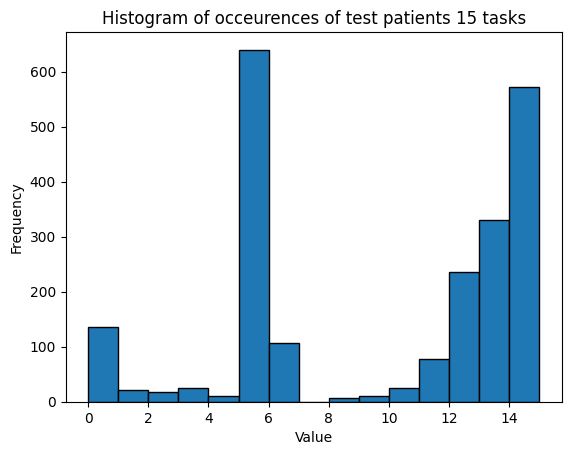

In [36]:
import matplotlib.pyplot as plt
num_tasks = []
for key, value in results_dict.items():
    num_tasks.append(len(value))
# Sample list of values
values_list = np.array(num_tasks)

# Create histogram
plt.hist(values_list, bins=len(set(values_list)), edgecolor='black')

# Add titles and labels
plt.title('Histogram of occeurences of test patients 15 tasks')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [41]:
results_dict.values()

dict_values([[{'lab_anemia': '8'}, {'guo_los': '1'}, {'guo_icu': '1'}, {'new_acutemi': '1'}, {'lab_hypoglycemia': '14'}, {'lab_hyponatremia': '8'}, {'lab_thrombocytopenia': '8'}, {'new_lupus': '1'}, {'new_celiac': '1'}, {'guo_readmission': '1'}, {'new_pancan': '1'}, {'lab_hyperkalemia': '7'}], [{'lab_anemia': '26'}, {'guo_los': '1'}, {'guo_icu': '1'}, {'new_acutemi': '1'}, {'lab_hypoglycemia': '34'}, {'new_hyperlipidemia': '1'}, {'lab_hyponatremia': '32'}, {'lab_thrombocytopenia': '26'}, {'new_lupus': '1'}, {'new_celiac': '1'}, {'new_pancan': '1'}, {'lab_hyperkalemia': '35'}], [{'lab_anemia': '24'}, {'guo_los': '1'}, {'guo_icu': '1'}, {'new_acutemi': '1'}, {'lab_hypoglycemia': '17'}, {'lab_hyponatremia': '18'}, {'lab_thrombocytopenia': '22'}, {'new_lupus': '1'}, {'new_celiac': '1'}, {'guo_readmission': '1'}, {'new_pancan': '1'}, {'lab_hyperkalemia': '18'}], [{'lab_anemia': '63'}, {'new_hypertension': '1'}, {'guo_los': '1'}, {'guo_icu': '1'}, {'new_acutemi': '1'}, {'lab_hypoglycemia': '

In [45]:
results_dict_specific = []
for key, value in results_dict.items():
    for val in value:
        results_dict_specific.append(val)

In [67]:
specific = []
for val in results_dict_specific:
    specific.append(list(val.values())[0])

In [73]:
specific_filtered = sorted(specific, reverse=True)

In [76]:
specific_filtered[20:]

[599,
 593,
 589,
 589,
 588,
 587,
 586,
 585,
 584,
 583,
 580,
 575,
 565,
 563,
 554,
 536,
 531,
 529,
 508,
 503,
 492,
 491,
 480,
 478,
 478,
 467,
 464,
 457,
 451,
 436,
 429,
 424,
 421,
 421,
 407,
 403,
 400,
 398,
 398,
 397,
 392,
 392,
 388,
 387,
 387,
 385,
 385,
 384,
 380,
 377,
 372,
 371,
 370,
 370,
 370,
 365,
 365,
 364,
 364,
 364,
 361,
 360,
 359,
 358,
 356,
 354,
 351,
 350,
 349,
 349,
 348,
 348,
 347,
 346,
 343,
 340,
 339,
 339,
 339,
 338,
 338,
 337,
 336,
 336,
 334,
 333,
 332,
 331,
 331,
 328,
 326,
 318,
 317,
 317,
 316,
 316,
 313,
 313,
 312,
 310,
 310,
 310,
 309,
 309,
 304,
 303,
 303,
 299,
 299,
 298,
 296,
 293,
 292,
 291,
 291,
 291,
 291,
 290,
 290,
 288,
 287,
 287,
 286,
 285,
 285,
 283,
 283,
 282,
 281,
 281,
 281,
 280,
 278,
 278,
 278,
 278,
 277,
 276,
 276,
 275,
 275,
 275,
 274,
 274,
 273,
 273,
 273,
 271,
 270,
 270,
 270,
 269,
 268,
 268,
 267,
 265,
 265,
 264,
 264,
 264,
 263,
 262,
 262,
 262,
 262,
 261,
 260

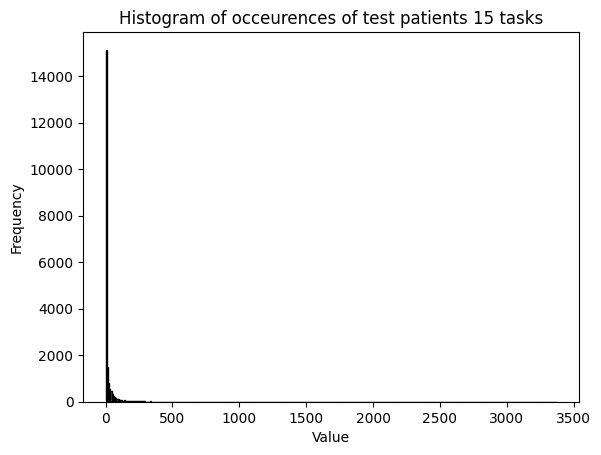

In [68]:
import matplotlib.pyplot as plt

# Create histogram
plt.hist(specific, bins=len(set(specific)), edgecolor='black')

# Add titles and labels
plt.title('Histogram of occeurences of test patients 15 tasks')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

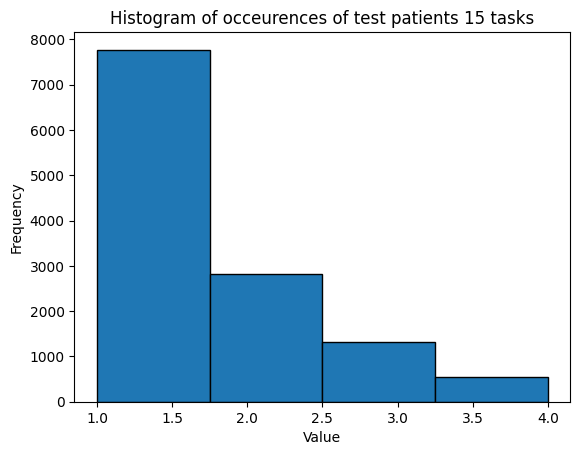

In [89]:
import matplotlib.pyplot as plt
k =8000
# Create histogram
plt.hist(specific_filtered[k:], bins=len(set(specific_filtered[k:])), edgecolor='black')

# Add titles and labels
plt.title('Histogram of occeurences of test patients 15 tasks')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [86]:
sum(np.array(specific) == 1)

7774

In [87]:
sum(np.array(specific) == 0)

0

In [3]:
with open('EHRSHOT_ASSETS/benchmark/guo_icu/all_shots_data.json', 'r') as f:
    data = json.load(f)

In [4]:
data['guo_icu'].keys()

dict_keys(['1', '2', '4', '8', '12', '16', '24', '32', '48', '64', '128', '-1'])

In [5]:
data['guo_icu']['1']['0']

{'patient_ids_train_k': [115970972, 115973215],
 'patient_ids_val_k': [115968080, 115967390],
 'label_times_train_k': ['2021-02-17T23:59:00', '2010-07-11T23:59:00'],
 'label_times_val_k': ['2014-11-27T23:59:00', '2018-06-06T23:59:00'],
 'label_values_train_k': [False, True],
 'label_values_val_k': [False, True],
 'train_idxs': [1316, 2143],
 'val_idxs': [292, 72]}

In [10]:
data['guo_icu']['128']['0'].keys()

dict_keys(['patient_ids_train_k', 'patient_ids_val_k', 'label_times_train_k', 'label_times_val_k', 'label_values_train_k', 'label_values_val_k', 'train_idxs', 'val_idxs'])

In [13]:
df['patient_id']

,patient_id,prediction_time,value,label_type
0,115973501,2014-09-19 10:04:00,0,categorical
1,115973501,2015-12-13 08:02:00,0,categorical
2,115973501,2017-03-13 08:28:00,1,categorical
3,115973501,2017-03-13 17:58:00,0,categorical
4,115973501,2017-05-18 10:26:00,0,categorical
...,...,...,...,...
200165,115967121,2023-02-10 09:23:00,0,categorical
200166,115967121,2023-02-12 08:44:00,0,categorical
200167,115967121,2023-02-16 10:45:00,0,categorical
200168,115967121,2023-02-23 09:17:00,0,categorical
